### Visualizing Machine Learning Thresholds to Make Better Business Decisions

In [17]:
# Imports 
import pandas as pd 
import bisect
import numpy as np 
import io
from sklearn.model_selection  import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_recall_curve 
from sklearn.preprocessing import LabelEncoder 
from scipy.stats import mstats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns
sns.set_style('darkgrid')

In [27]:
df = pd.read_csv('churn.txt') 

In [28]:
df.shape

(3333, 21)

In [29]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


### **PRE PROCESSING**

In [30]:
df.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "") for c in df.columns] 

In [31]:
state_encoder = LabelEncoder() 
df.state = state_encoder.fit_transform(df.state) 

In [32]:
del df['phone'] 
binary_columns = ['intl_plan', 'vmail_plan', 'churn'] 

for col in binary_columns: 
    df[col] = df[col].map({ 
        'no': 0
    ,   'False.': 0
    ,   'yes': 1
    ,   'True.': 1 
    })

In [33]:
df.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [35]:
features = df[[c for c in df.columns if c != 'churn']] 
labels = df['churn'] 
test_size_percent = 0.1 
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=test_size_percent) 

In [36]:
clf = RandomForestClassifier(n_estimators=50, oob_score=True) 
clf.fit(train_features, train_labels) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
predictions = clf.predict_proba(test_features)[:,1]

In [41]:
predictions[:10]

array([0.58, 0.2 , 0.04, 0.  , 0.2 , 0.08, 0.06, 0.02, 0.04, 0.04])

In [42]:
precision, recall, thresholds = precision_recall_curve(test_labels, predictions) 

In [47]:
pd.DataFrame({'precision':precision,'recall':recall,'threshold':thresholds}).head()

,precision,recall,threshold
0,0.119760,1.000,0.00
1,0.135714,0.950,0.02
2,0.172897,0.925,0.04
3,0.215569,0.900,0.06
4,0.253623,0.875,0.08


In [44]:
thresholds = np.append(thresholds, 1) 

In [45]:
thresholds

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.4 , 0.46, 0.52, 0.54,
       0.56, 0.58, 0.62, 0.64, 0.66, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 ,
       0.82, 0.84, 0.86, 0.9 , 0.92, 0.94, 0.98, 1.  ])

### **Visualizing Thresholding Decisions**

There are three factors to consider when choosing a threshold point:   
**Queue Rate:** How many cases do you want to act on? 
This will depend on the cost of treating an individual case, as well as your overall capacity. If you’re asking a team of reviewers to look at potential fake accounts, then the number of cases you can flag is limited by the resources of that team: How many cases do they have the ability to review within your timeframe? If, on the other hand, you’re sending out mass emails, your variable cost is nearly zero, and you can afford to queue a lot of cases. Etc.

**Precision:** What’s the downside when you erroneously queue a case? If you’re reviewing fraudulent accounts, the cost is wasted reviewer time. If you mistakenly send a 10% off coupon to someone who would have completed his or her purchase anyway, your cost is 10% of their shopping cart. Etc.

**Recall:** What’s the downside when you fail to queue a case that should have been queued? If you’re queueing sales leads, you’re losing the value of a missed opportunity. If you’re reviewing fake accounts, the cost is tied to the cost of having fraudulent accounts in your network. Etc.

Text(0, 0.5, '%')

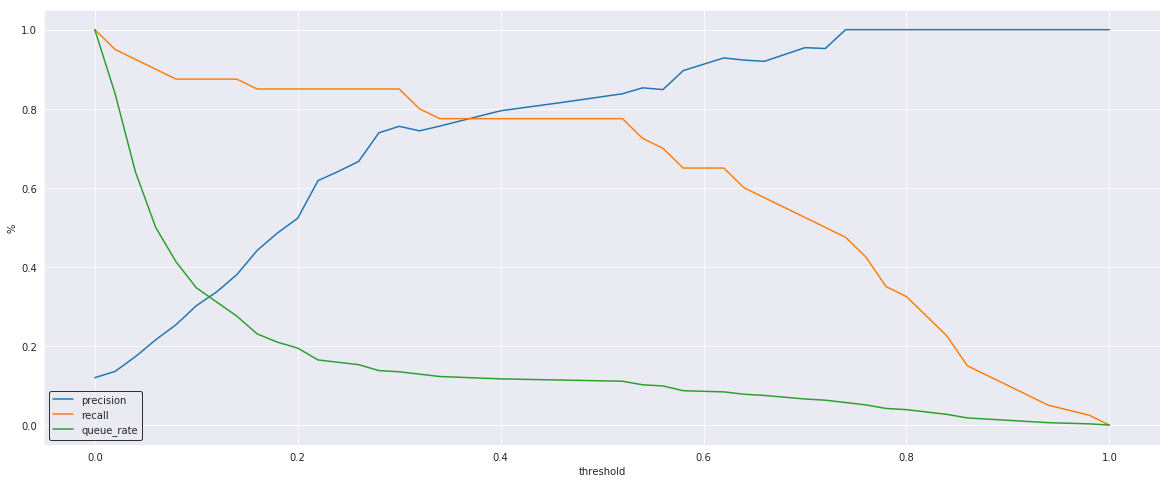

In [52]:
queue_rate = [] 
for threshold in thresholds: 
    queue_rate.append((predictions >= threshold).mean()) 
    
plt.figure(figsize=(20,8))    
plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2]) 
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('%')

**Here’s how we can read this chart:**  
For a given threshold on the x-axis, we can see queue rate, precision, and recall expressed as percentages against the y-axis.

For example, if we choose a threshold of 0.4 (all cases with a score above 0.4 get reviewed / sent an offer / whatever treatment we have at hand), then:  
**About 14% of cases will be queued.**So if 10k accounts are scored for churn each day, about 1400 of them will be selected for special treatment.   
**Our precision will be about 92%.** So of the cases we queue, 92% will really go on to churn if we don’t intervene.   
**Our recall will be about 80%.** Of all users who will churn before the next billing period, we’ll catch 80% with our model.

**Of course, 0.4 might not be the best threshold value for this particular company.**  
If, for example, you only have the capacity to act on 500 cases (5% of the hypothetical 10k scored cases) per period, then you’re bound to choose a threshold around 0.8, in which case your precision jumps to 100% but your recall drops to ~35%.   

The point is that with this chart, you are now equipped to make informed decisions about where to set your threshold.


----

### Dealing with Model Variability

The chart we produced above only shows the performance of a single train/test split.   
While we’d hope that this sample is indicative of likely model performance, it’s better to visualize many train/test splits to get an idea of the range of possible performance outcomes.   
One of the simplest ways to do this is to perform many random train/test splits, and plot the curves for each.   

**Here’s what that looks like for 50 random splits on the telecom churn model:**

In [53]:
clf = RandomForestClassifier(n_estimators=50, oob_score=True)

n_trials = 50
test_size_percent = 0.1

signals = df[[c for c in df.columns if c != 'churn']]
labels = df['churn']

plot_data = []

for trial in range(n_trials):
    train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent)
    clf.fit(train_signals, train_labels)
    predictions = clf.predict_proba(test_signals)[:,1]
    
    precision, recall, thresholds = precision_recall_curve(test_labels, predictions)
    thresholds = np.append(thresholds, 1)
    
    queue_rate = []
    for threshold in thresholds:
        queue_rate.append((predictions >= threshold).mean())
            
    plot_data.append({
            'thresholds': thresholds
        ,   'precision': precision
        ,   'recall': recall
        ,   'queue_rate': queue_rate
    })

Text(0, 0.5, '%')

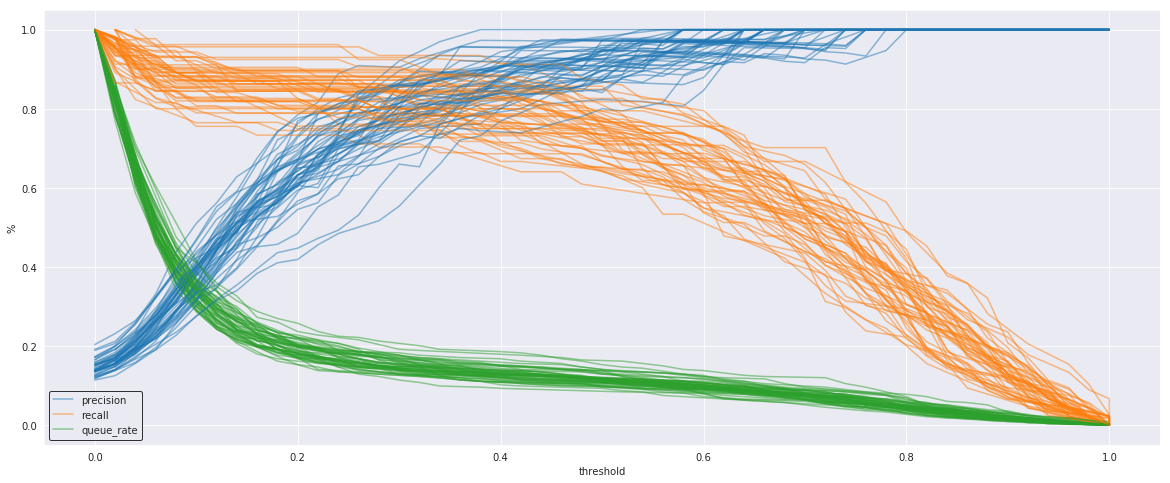

In [57]:
plt.figure(figsize=(20,8))    
for p in plot_data:
    plt.plot(p['thresholds'], p['precision'], color=sns.color_palette()[0], alpha=0.5)
    plt.plot(p['thresholds'], p['recall'], color=sns.color_palette()[1], alpha=0.5)
    plt.plot(p['thresholds'], p['queue_rate'], color=sns.color_palette()[2], alpha=0.5)
    

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')

As expected, there’s some variation. Earlier, when we were just looking at a single train/test split, we said that with a threshold of 0.4, we’d expect:  
Queue rate of about 14%.  
Precision of about 92%.  
Recall of about 80%.  


Now we see that there is more uncertainty around these numbers. Looking at the new chart, which shows 50 train/test splits, we might now say instead that a threshold of 0.4 would produce:  
A queue rate of between 10% and 20%  
Precision of between 70% and 100%  
Recall of between 60% and 90%.  

---

We can make more precise statements with a statistical visualization. Let’s plot the median curves, along with a 90% central interval for each threshold:

In [10]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_precision_plots = []
uniform_recall_plots= []
uniform_queue_rate_plots= []

for p in plot_data:
    uniform_precision = []
    uniform_recall = []
    uniform_queue_rate = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        uniform_precision.append(p['precision'][index])
        uniform_recall.append(p['recall'][index])
        uniform_queue_rate.append(p['queue_rate'][index])
        
    uniform_precision_plots.append(uniform_precision)
    uniform_recall_plots.append(uniform_recall)
    uniform_queue_rate_plots.append(uniform_queue_rate)

Text(0, 0.5, '%')

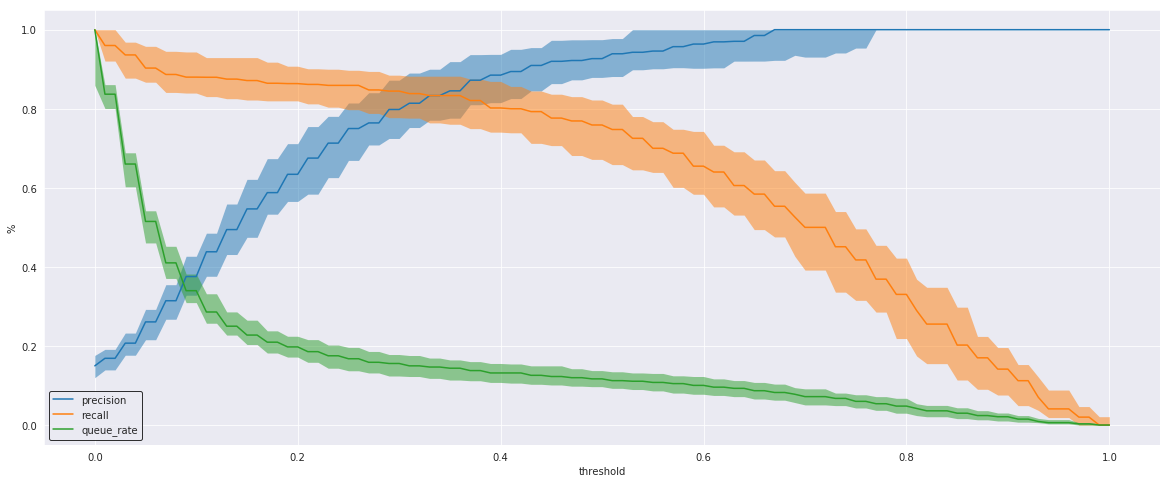

In [58]:

quantiles = [0.1, 0.5, 0.9]
lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0)
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0)
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0)

plt.figure(figsize=(20,8))    
plt.plot(uniform_thresholds, median_precision)
plt.plot(uniform_thresholds, median_recall)
plt.plot(uniform_thresholds, median_queue_rate)

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0])
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1])
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2])

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')

Now we can be considerably more precise by saying that for a threshold of 0.4, we expect:   
A 90% chance that our queue rate will be between ~11% and ~15%, with median value ~13%.  
A 90% chance that our precision will be between ~80% and ~95%, with median value ~90%.  
A 90% chance that our recall will be between ~70% and ~85% with a median value ~80%.  
With this chart, we can say quite a lot about the likely outcomes of different threshold choices under realistic conditions.  

---

### Thresholding Like an Owner

One of the things I love about the last chart is that it empowers you to make business decisions based on your ML work.   
This gives you the opportunity to move beyond the technical role of building a model into the role of deciding what to actually do with your model.  
All you need to get started is the chart above and some back of the envelope numbers for cost/benefit analysis.

As a simple example, let’s say that your company’s churn prevention strategy is to make direct phone calls to each churn-risky user (defined as users whose churn score is above the threshold you set).   

To keep things easy, we’ll assume unrealistically that this strategy always works:   
If a user who was going to churn gets a phone call, he or she will not churn.   
Your retention team has 3 members, each of whom can make 333 calls per period; so you can make a total of 1000 calls per period.   
Let’s say again that you get 10k cases to score each period, that the cost of labor in making a phone call is 20, and that if a user churns, you lose 100.  
These estimates need not be perfect for our purposes; we’re looking for a back of the envelope calculation.

So right now, on the curve, you’re going to set a threshold of about 0.57: That will give you a queue rate of 10.03% = 1003 cases, and that’s all you can handle.    
The chart also shows you uncertainty. You know, e.g., that with a threshold of 0.57, you’ll end up between about 8.4% = 840 and 11.4% = 1140 cases.   

If you know that your team absolutely cannot handle more than 1000 cases, then you should leave some room: Choose a lower threshold (e.g. 0.65) so that the 90% interval lies below your 1000 case limit.   
Even more importantly: Because you have your chart, you can see that having a 1000 call capacity is suboptimal for your business; the clue is the fact that recall is so low.   

Right now, your total cost is around $20 x 1000 = 20,000 and, since your precision is 96%, you’re making about 0.96 x 100 x 1000 = 96,000 in saved account "revenue", making the total profit of your operation about 76,000.   

But what if you doubled your budget? Then you could review 2k cases, your cost would be 40,000, your  precision  would  be about 61% and you’d make 0.61 x 100 x 2000 = 122,000 in revenue, making your profit around 82,000.

Your chart just helped you make 6,000 per period.    
This was just an educated guess about a better threshold; if we poke around a bit more, we find that the optimal threshold for these specific cost estimates is 0.33, which gives us a median profit of about $90,700.

Text(0, 0.5, '$')

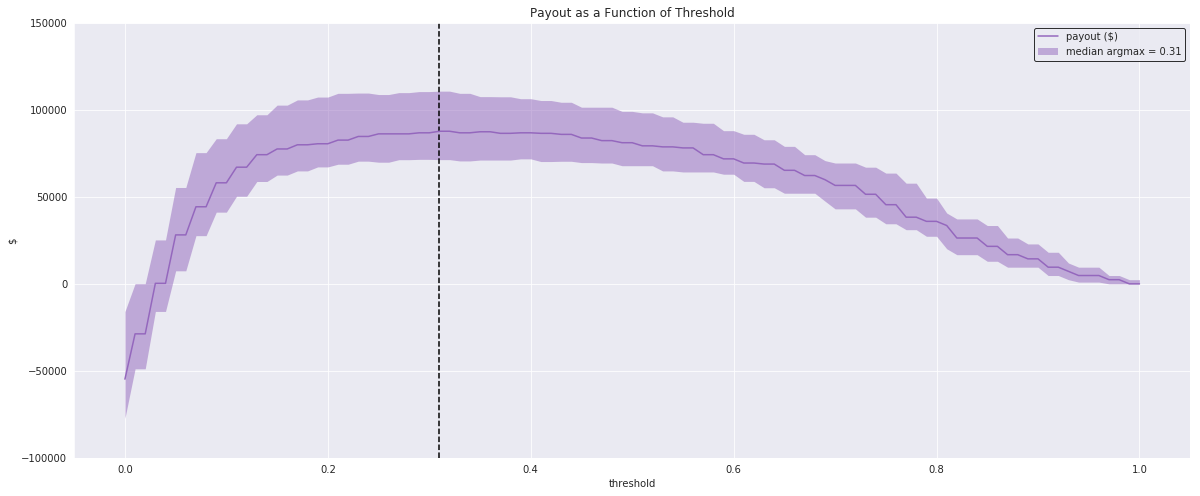

In [59]:
uniform_thresholds = np.linspace(0, 1, 101)

uniform_payout_plots = []

n = 10000
success_payoff = 100
case_cost = 20

for p in plot_data:
    uniform_payout = []
    for ut in uniform_thresholds:
        index = bisect.bisect_left(p['thresholds'], ut)
        precision = p['precision'][index]
        queue_rate = p['queue_rate'][index]
        
        payout = n*queue_rate*(precision*100 - case_cost)
        uniform_payout.append(payout)

    uniform_payout_plots.append(uniform_payout)

quantiles = [0.1, 0.5, 0.9]
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0)

plt.figure(figsize=(20,8))    
plt.plot(uniform_thresholds, median_payout, color=sns.color_palette()[4])
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4])

max_ap = uniform_thresholds[np.argmax(median_payout)]
plt.vlines([max_ap], -100000, 150000, linestyles='--')
plt.ylim(-100000, 150000)

leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.title("Payout as a Function of Threshold")
plt.ylabel('$')

In [13]:
print(np.max(median_payout))

92514.97005988023


We can also see that there’s a lot of uncertainty in the profitability of our operation; knowing this ahead of time let’s you move more confidently when natural variation occurs.   

(As a side note, it’s worth pointing out too that if we had used the naive value of 0.5 (i.e. queue cases with churn score above 0.5, ignore cases below 0.5), which is a common default value for classifiers, we would have created far less value than we were able to do do by using our thresholding chart. With a threshold of 0.5 and review capacity to match, we would have made about 84,000 rather than 89,200, more than a 5,000 difference per period!)   

In general, using the queue rate / precision / recall graph is an easy way to perform “what if” analysis on the operational and strategic decision of how your model can be best used.  
Thresholding is a simple and effective strategy for creating value from a machine learning classifier. Once you’ve decided to threshold, data visualization techniques like the ones in this post will let you understand the tradeoffs you face for each possible threshold choice — and thus help you choose the most value-creating threshold for your particular business application.

### REFERENCES

[Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)